In [1]:
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt


In [2]:
name = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [3]:
train_filename = "data/train.csv" 

In [22]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.
        
        image = images[i].reshape(48, 48)
        
        
        # Ensure the noisy pixel-values are between 0 and 1.
        #image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image,
                  cmap = 'gray',
                  interpolation='nearest')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True:{0}".format(name[cls_true[i]])
        else:
            xlabel = "True:{0}, Pred:{1}".format(name[cls_true[i]], name[cls_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
class clean_data(object):
    _train = True
    
    def __init__(self, filename, train=True):
        self._train = train
        self._train_df = pd.read_csv(filename)
        self._train_df['feature'] = self._train_df['feature'].map(lambda x : np.array(list(map(float, x.split()))))
        self._image_size = self._train_df.feature[0].size
        self._image_shape = (int(np.sqrt(self._image_size)), int(np.sqrt(self._image_size)))
        self._dataNum = self._train_df.size
        self._feature = np.array(self._train_df.feature.map(lambda x: x.reshape(self._image_shape)).values.tolist())
        if self._train:
            self._label = self._train_df.label.values
            self._labelNum = self._train_df['label'].unique().size
            self._onehot = pd.get_dummies(self._train_df.label).values


    @property
    def distribution(self):
        return self._distribution
    
    @property
    def image_size(self):
        return self._image_size
    
    @property
    def image_shape(self):
        return self._image_shape
    
    @property
    def dataNum(self):
        return self._dataNum
    
    @property
    def feature(self):
        return self._feature
    
    if _train:
        @property
        def label(self):
            return self._label

        @property
        def labelNum(self):
            return self._labelNum
        
        @property
        def onehot(self):
            return self._onehot
    

In [6]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model

from sklearn.utils.class_weight import compute_class_weight

In [7]:
train_data = clean_data('data/train.csv')
test_data = clean_data('data/test.csv', False)

In [8]:
train = train_data.feature.reshape((-1, 48, 48, 1))/255
train_x = train[:-2000]
train_label = train_data.label[:-2000]
train_onehot = train_data.onehot[:-2000]
test_x = train[-2000:]
test_label = train_data.label[-2000:]
test_onehot = train_data.onehot[-2000:]

In [9]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_data.label),
                                    y=train_data.label)

In [10]:
class_weight

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.84912748,
       1.29337298, 0.82603942])

In [11]:
inputs = Input(shape=(48,48,1))

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
             activation='relu', name='layer_conv1')(inputs)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.25)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=128, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.25)(net)

# Third convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=256, padding='same',
             activation='relu', name='layer_conv3')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.5)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128)(net)
net = BatchNormalization(axis = -1)(net)
net = Activation('relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(7)(net)
net = BatchNormalization(axis = -1)(net)
net = Activation('softmax')(net)
# Output of the Neural Network.
outputs = net

In [12]:

model = Model(inputs=inputs, outputs=outputs)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [13]:
y = model.fit(x=train_x,
           y=train_onehot,
           validation_data=(test_x, test_onehot),
           class_weight=class_weight,
           epochs=100, batch_size=64,
           callbacks=[tensorboard]
             )

Train on 26709 samples, validate on 2000 samples
Epoch 1/100
26709/26709 [==============================] - 21s 768us/step - loss: 1.6280 - acc: 0.3870 - val_loss: 1.7042 - val_acc: 0.3275
Epoch 2/100
26709/26709 [==============================] - 19s 722us/step - loss: 1.3525 - acc: 0.4946 - val_loss: 1.6301 - val_acc: 0.3920
Epoch 3/100
26709/26709 [==============================] - 19s 723us/step - loss: 1.2318 - acc: 0.5429 - val_loss: 1.5813 - val_acc: 0.3805
Epoch 4/100
26709/26709 [==============================] - 19s 712us/step - loss: 1.1444 - acc: 0.5733 - val_loss: 1.2311 - val_acc: 0.5320
Epoch 5/100
26709/26709 [==============================] - 19s 717us/step - loss: 1.0623 - acc: 0.6091 - val_loss: 1.1620 - val_acc: 0.5605
Epoch 6/100
26709/26709 [==============================] - 19s 707us/step - loss: 0.9852 - acc: 0.6434 - val_loss: 1.2354 - val_acc: 0.5425
Epoch 7/100
26709/26709 [==============================] - 19s 706us/step - loss: 0.9127 - acc: 0.6671 - val_lo

Epoch 59/100
26709/26709 [==============================] - 19s 699us/step - loss: 0.1281 - acc: 0.9570 - val_loss: 1.6485 - val_acc: 0.6230
Epoch 60/100
26709/26709 [==============================] - 19s 700us/step - loss: 0.1263 - acc: 0.9571 - val_loss: 1.6905 - val_acc: 0.6035
Epoch 61/100
26709/26709 [==============================] - 19s 701us/step - loss: 0.1245 - acc: 0.9584 - val_loss: 1.6212 - val_acc: 0.5885
Epoch 62/100
26709/26709 [==============================] - 19s 702us/step - loss: 0.1193 - acc: 0.9599 - val_loss: 1.6443 - val_acc: 0.6060
Epoch 63/100
26709/26709 [==============================] - 19s 700us/step - loss: 0.1209 - acc: 0.9596 - val_loss: 1.6963 - val_acc: 0.6140
Epoch 64/100
26709/26709 [==============================] - 19s 701us/step - loss: 0.1187 - acc: 0.9604 - val_loss: 1.6625 - val_acc: 0.6105
Epoch 65/100
26709/26709 [==============================] - 19s 700us/step - loss: 0.1204 - acc: 0.9600 - val_loss: 1.5854 - val_acc: 0.6085
Epoch 66/100


In [14]:
def plot_training_history(r):
    # plot some data
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    # accuracies
    plt.plot(r.history['acc'], label='acc')
    plt.plot(r.history['val_acc'], label='val_acc')
    plt.legend()
    plt.show()

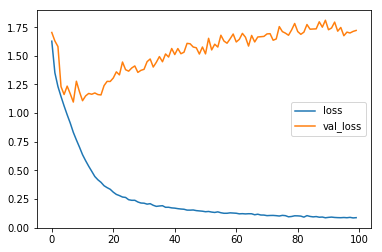

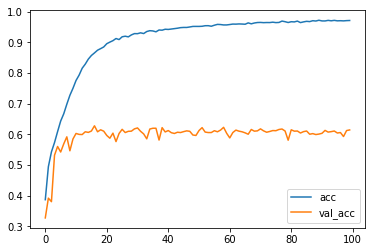

In [15]:
plot_training_history(y)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
__________

In [17]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != test_label)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_x[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_label[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [18]:
y_pred = model.predict(x=test_x)
cls_pred = np.argmax(y_pred, axis=1)

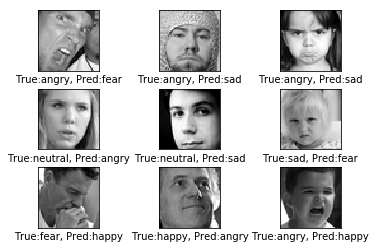

In [23]:
plot_example_errors(cls_pred)

In [24]:
model.save('cnn.h5')

In [25]:
del model

In [41]:
inputs = Input(shape=(48,48,1))

dnn = Flatten()(inputs)

dnn = Dense(512)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('relu')(dnn)
dnn = Dropout(0.25)(dnn)

dnn = Dense(1024)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('relu')(dnn)
dnn = Dropout(0.5)(dnn)

dnn = Dense(512)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('relu')(dnn)
dnn = Dropout(0.5)(dnn)

dnn = Dense(7)(dnn)
dnn = BatchNormalization(axis = -1)(dnn)
dnn = Activation('softmax')(dnn)

outputs = dnn

In [42]:
model2 = Model(inputs=inputs, outputs=outputs)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model2.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [44]:
d = model2.fit(x=train_x,
           y=train_onehot,
           validation_data=(test_x, test_onehot),
           class_weight=class_weight,
           epochs=100, batch_size=64,
           callbacks=[tensorboard]
             )

Train on 26709 samples, validate on 2000 samples
Epoch 1/100
26709/26709 [==============================] - 5s 171us/step - loss: 1.8011 - acc: 0.3066 - val_loss: 1.6959 - val_acc: 0.3500
Epoch 2/100
26709/26709 [==============================] - 4s 145us/step - loss: 1.6445 - acc: 0.3686 - val_loss: 1.6930 - val_acc: 0.3405
Epoch 3/100
26709/26709 [==============================] - 4s 149us/step - loss: 1.5837 - acc: 0.3886 - val_loss: 1.6155 - val_acc: 0.3810
Epoch 4/100
26709/26709 [==============================] - 4s 151us/step - loss: 1.5424 - acc: 0.4102 - val_loss: 1.6482 - val_acc: 0.3275
Epoch 5/100
26709/26709 [==============================] - 4s 149us/step - loss: 1.5071 - acc: 0.4214 - val_loss: 1.6436 - val_acc: 0.3355
Epoch 6/100
26709/26709 [==============================] - 4s 147us/step - loss: 1.4786 - acc: 0.4310 - val_loss: 1.7105 - val_acc: 0.3020
Epoch 7/100
26709/26709 [==============================] - 4s 160us/step - loss: 1.4512 - acc: 0.4396 - val_loss: 1.7

In [43]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               1180160   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              525312    
__________

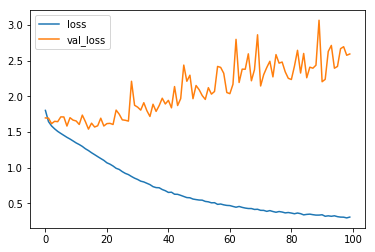

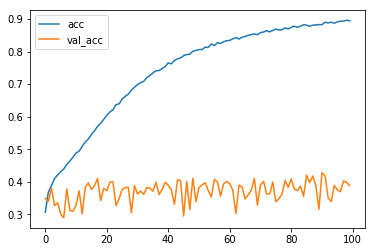

In [46]:
plot_training_history(d)

In [47]:
model2.save('dnn.h5')